# Imports

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, BatchNormalization, Input, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()
tf.keras.backend.set_floatx('float64')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1496036034730054253
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10365570952846134388
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3127299276
locality {
  bus_id: 1
  links {
  }
}
incarnation: 628355134806114381
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17319808248378968772
physical_device_desc: "device: XLA_GPU device"
]


# Preprocess data

## Extract raw data and selected desired columns

In [6]:
dados = pd.read_csv('Dados/dados originais.csv',sep=';').drop(['id','Unique_id'],axis=1)
dados=dados[dados['vaccinedose_PLACEBO']==0]

def convert(x):
    try:
        x = int(x)
        return float(x)
    except:
        return float(x.replace(',','.'))
for col in dados.columns:
    dados[col] = dados[col].apply(lambda x:convert(x))
    
X = dados.iloc[:,3:-23]
colsX = list(X.columns)
Y = dados.iloc[:,-8:]
colsY = list(Y.columns)
X.index = range(len(X))
Y.index = range(len(Y))
print(f"Shape X: {X.shape}")
print(f"Shape Y: {Y.shape}")

Shape X: (363, 141)
Shape Y: (363, 8)


## De-log and normalize

In [7]:
X = 2**X
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = colsX
X

,BCL2,BLR1,BMP6,BPI,CAMTA1,CASP8,CCL2,CCL3,CCL4,CCL5,...,TLR10,TNF,TNFRSF1A,TNFRSF1B,TNFRSF18,TNIP1,TWIST1,VEGF,ZNF331,ZNF532
0,0.166472,0.063108,0.008375,0.048233,0.000000,0.480825,0.000000,0.00000,0.135281,0.481678,...,0.000000,0.008869,0.324297,0.667481,0.004759,0.010257,0.0,0.000000,0.055700,0.000000
1,0.088291,0.037261,0.005805,0.040766,0.000000,0.487687,0.000000,0.00000,0.111837,0.279471,...,0.000000,0.006003,0.478663,0.681901,0.005203,0.070248,0.0,0.000000,0.000000,0.000000
2,0.177581,0.068813,0.005525,0.060332,0.000000,0.586110,0.000000,0.00000,0.132248,0.301811,...,0.000000,0.010378,0.520902,0.972141,0.005203,0.064849,0.0,0.000000,0.000000,0.000000
3,0.130992,0.051503,0.006319,0.060332,0.000000,0.577893,0.000000,0.00000,0.095053,0.264261,...,0.000000,0.008225,0.517246,0.979033,0.006402,0.052828,0.0,0.000000,0.016664,0.000000
4,0.195444,0.039247,0.005003,0.034444,0.000000,0.477430,0.000000,0.03716,0.101948,0.351940,...,0.000000,0.007062,0.535781,0.630461,0.003776,0.054406,0.0,0.000000,0.004568,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,0.189324,0.047526,0.003169,0.008871,0.072400,0.167958,0.000000,0.00000,0.165606,0.067996,...,0.000000,0.009489,0.161480,0.019325,0.028807,0.040132,0.0,0.024561,0.076507,0.014618
359,0.177581,0.053414,0.005147,0.011862,0.000000,0.142688,0.001116,0.00000,0.225647,0.005783,...,0.061217,0.010691,0.135456,0.076385,0.000000,0.055618,0.0,0.043344,0.000000,0.000000
360,0.000000,0.063565,0.007973,0.015808,0.099507,0.120082,0.000000,0.00000,0.260995,0.126339,...,0.374705,0.012484,0.119474,0.095182,0.059879,0.134896,0.0,0.093799,0.088757,0.026485
361,0.177581,0.045816,0.004249,0.010189,0.000000,0.161872,0.000000,0.00000,0.202173,0.003565,...,0.059347,0.011598,0.134463,0.033280,0.000000,0.053611,0.0,0.029375,0.000000,0.000000


In [38]:
len(Counter(y_soma[:,0]))

9

# Deep Learning

## CNN

### If pacient had any events

In [58]:
n_splits = 4
test_size = 0.3 
num_genes_fold = 15
num_genes_final = 8
folds = 10
epochs = 40
batch_size = 16


X = np.array(X)
X = X.reshape((X.shape[0],47,3))

y_soma = pd.DataFrame(Y.sum(axis=1),columns=['Class'])
y_soma['Class']=y_soma['Class'].apply(lambda x: 1 if x!=0 else 0)
y_soma = np.array(y_soma)

input_shape = (47,3)
num_classes  = len(Counter(y_soma[:,0]))

X_train,X_test,y_train,y_test = train_test_split(X,y_soma,test_size = test_size)
activation = 'relu'
activation_dense = 'relu'

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, padding='same', input_shape=input_shape, activation=activation))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation=activation_dense)) 
model.add(Dropout(0.1))
model.add(Dense(512, activation=activation_dense)) 
model.add(Dropout(0.1))
model.add(Dense(1024, activation=activation_dense))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle='True', 
                 validation_data=(X_test, y_test))

Epoch 1/40
16/16 [==============================] - 0s 27ms/step - loss: 0.6823 - accuracy: 0.5984 - val_loss: 0.6615 - val_accuracy: 0.6422
Epoch 2/40
16/16 [==============================] - 0s 13ms/step - loss: 0.6682 - accuracy: 0.6142 - val_loss: 0.6532 - val_accuracy: 0.6422
Epoch 3/40
16/16 [==============================] - 0s 12ms/step - loss: 0.6620 - accuracy: 0.6142 - val_loss: 0.6478 - val_accuracy: 0.6422
Epoch 4/40
16/16 [==============================] - 0s 11ms/step - loss: 0.6531 - accuracy: 0.6142 - val_loss: 0.6581 - val_accuracy: 0.6422
Epoch 5/40
16/16 [==============================] - 0s 11ms/step - loss: 0.6432 - accuracy: 0.6102 - val_loss: 0.6525 - val_accuracy: 0.6514
Epoch 6/40
16/16 [==============================] - 0s 11ms/step - loss: 0.6332 - accuracy: 0.5827 - val_loss: 0.6719 - val_accuracy: 0.6514
Epoch 7/40
16/16 [==============================] - 0s 12ms/step - loss: 0.5938 - accuracy: 0.6535 - val_loss: 0.6651 - val_accuracy: 0.6239
Epoch 8/40
16

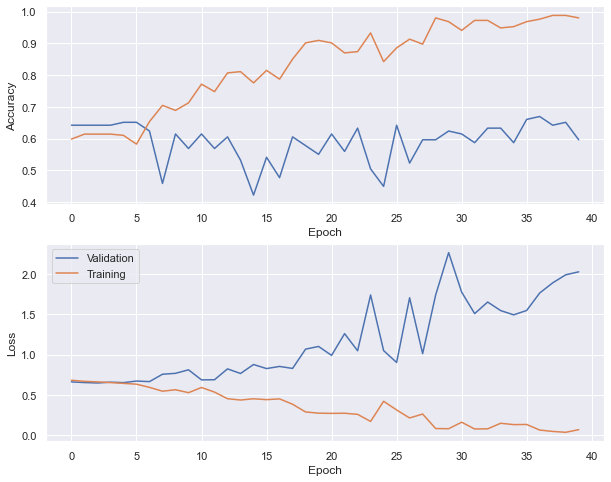

In [59]:
fig,axs=plt.subplots(2)

fig.set_size_inches(10,8)

axs[0].plot(hist.history['val_accuracy'],label='Validation')
axs[0].plot(hist.history['accuracy'],label='Training')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[1].plot(hist.history['val_loss'],label='Validation')
axs[1].plot(hist.history['loss'],label='Training')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

plt.legend();